In [1]:
%pip install lifelines
%pip install seaborn


  Using cached lifelines-0.30.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached autograd-gamma-0.5.0.tar.gz (4.0 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached interface_meta-1.3.0-py3-none-any.whl.metadata (6.7 kB)
Using cached lifelines-0.30.0-py3-none-any.whl (349 kB)
Using cached interface_meta-1.3.0-py3-none-any.whl (14 kB)
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=de0a1fde59264aedb98a47a52d8101c74932f3f48dd5733a68ce839eccf1b523
  Stored in directory: c:\users\shri\appdata\local\pip\cache\wheels\7e\16\46\9477f188924292d3bf1fb8fb42844201591abfc19b7ba6d868
Successfully built autograd-gamma

   ---------------------------------------- 0/4 [interface-meta]
   -------------------- ------------------- 2/4 [formulaic]
   -------------------- ------------------- 2/4 [formulaic]
   -------------------- ------------------- 2/4 [formulaic]
   ----------------

  DEPRECATION: Building 'autograd-gamma' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'autograd-gamma'. Discussion can be found at https://github.com/pypa/pip/issues/6334


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
patient_data = pd.read_csv('Breast_cancer_dataset.csv')
patient_data.head()

Patient ID  Age at Diagnosis Type of Breast Surgery    Cancer Type                       Cancer Type Detailed Cellularity Chemotherapy Pam50 + Claudin-low subtype  Cohort ER status measured by IHC ER Status  Neoplasm Histologic Grade HER2 status measured by SNP6 HER2 Status Tumor Other Histologic Subtype Hormone Therapy Inferred Menopausal State Integrative Cluster Primary Tumor Laterality  Lymph nodes examined positive  Mutation Count  Nottingham prognostic index Oncotree Code  Overall Survival (Months) Overall Survival Status PR Status Radio Therapy  Relapse Free Status (Months) Relapse Free Status     Sex 3-Gene classifier subtype  Tumor Size  Tumor Stage Patient's Vital Status
0    MB-0000             75.65             Mastectomy  Breast Cancer           Breast Invasive Ductal Carcinoma         NaN           No                 claudin-low     1.0                   Positve  Positive                        3.0                      Neutral    Negative                     Ductal/NST             Yes                      Post                4ER+                    Right                           10.0             NaN                        6.044           IDC                 140.500000                  Living  Negative           Yes                        138.65        Not Recurred  Female                 ER-/HER2-        22.0          2.0                 Living
1    MB-0002             43.19      Breast Conserving  Breast Cancer           Breast Invasive Ductal Carcinoma        High           No                        LumA     1.0                   Positve  Positive                        3.0                      Neutral    Negative                     Ductal/NST             Yes                       Pre                4ER+                    Right                            0.0             2.0                        4.020           IDC                  84.633333                  Living  Positive           Yes                         83.52        Not Recurred  Female     ER+/HER2- High Prolif        10.0          1.0                 Living
2    MB-0005             48.87             Mastectomy  Breast Cancer           Breast Invasive Ductal Carcinoma        High          Yes                        LumB     1.0                   Positve  Positive                        2.0                      Neutral    Negative                     Ductal/NST             Yes                       Pre                   3                    Right                            1.0             2.0                        4.030           IDC                 163.700000                Deceased  Positive            No                        151.28            Recurred  Female                       NaN        15.0          2.0        Died of Disease
3    MB-0006             47.68             Mastectomy  Breast Cancer  Breast Mixed Ductal and Lobular Carcinoma    Moderate          Yes                        LumB     1.0                   Positve  Positive                        2.0                      Neutral    Negative                          Mixed             Yes                       Pre                   9                    Right                            3.0             1.0                        4.050          MDLC                 164.933333                  Living  Positive           Yes                        162.76        Not Recurred  Female                       NaN        25.0          2.0                 Living
4    MB-0008             76.97             Mastectomy  Breast Cancer  Breast Mixed Ductal and Lobular Carcinoma        High          Yes                        LumB     1.0                   Positve  Positive                        3.0                      Neutral    Negative                          Mixed             Yes                      Post                   9                    Right                            8.0             2.0                        6.080          MDLC                  41.366667                Deceased  Posit

In [7]:
patient_data.shape

(2509, 34)

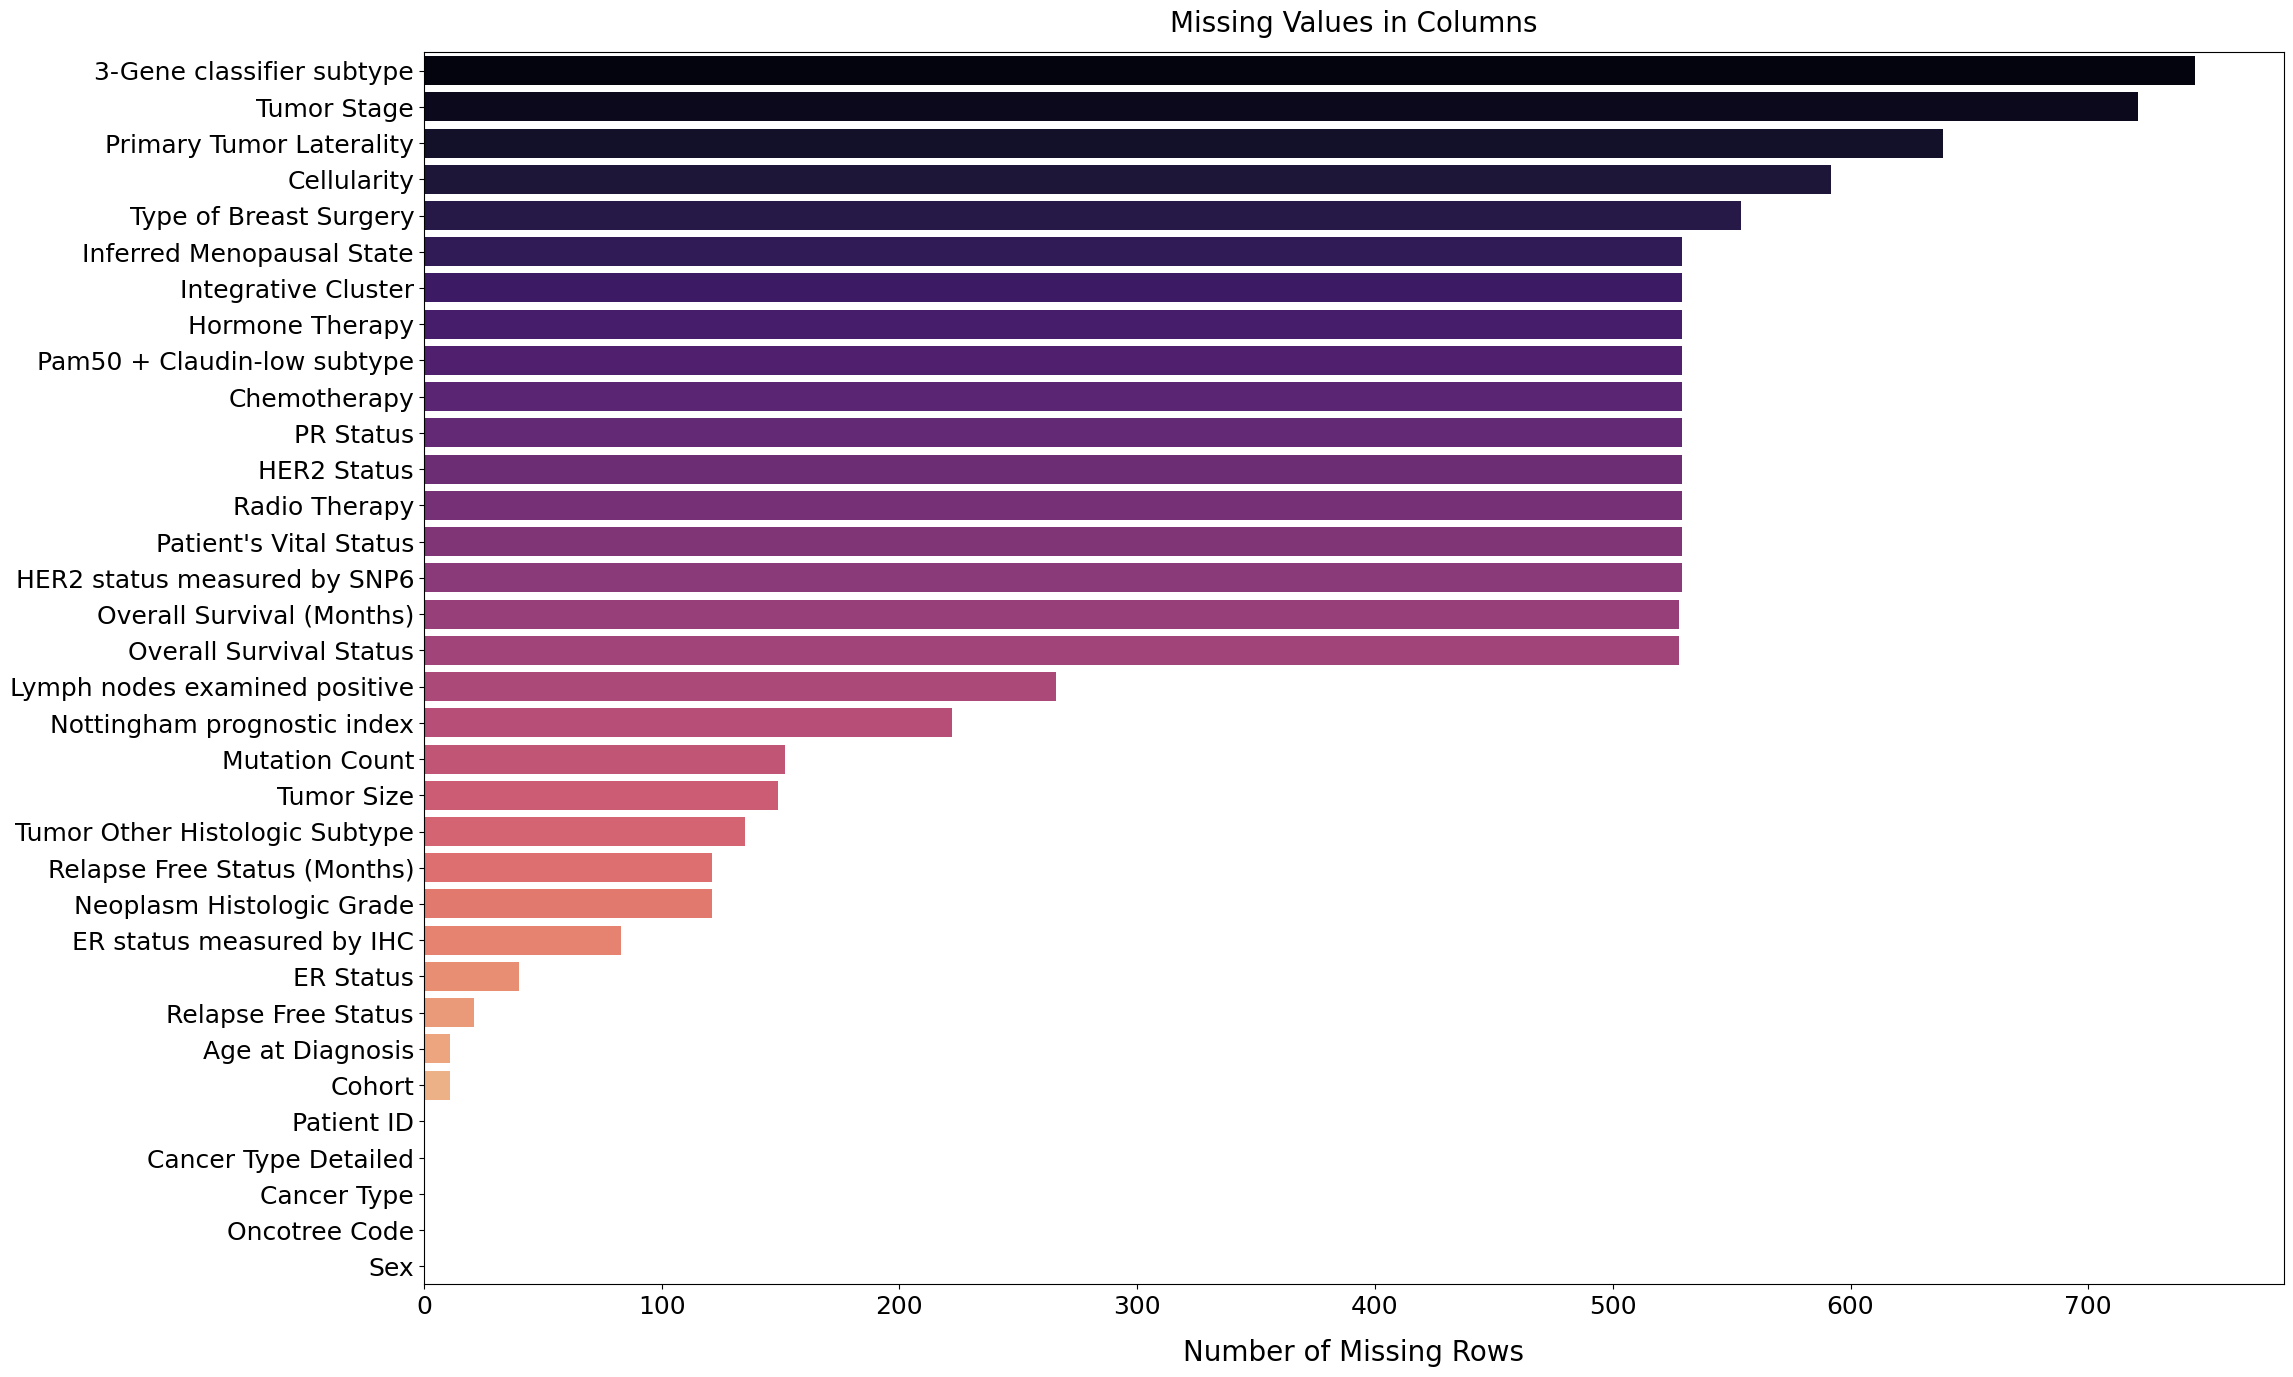

In [8]:
fig = plt.figure(figsize=(24, 16))

sns.barplot(x=patient_data.isnull().sum().sort_values(ascending=False).values,
            y=patient_data.isnull().sum().sort_values(ascending=False).index,
            palette='magma')

plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Missing Values in Columns', size=20, pad=15)

plt.show()

In [9]:

def safe_mode(series):
    mode_value = series.mode()
    return mode_value.iloc[0] if not mode_value.empty else np.nan

# Filling categorical columns using mode
patient_data['Relapse Free Status'] = patient_data.groupby(['Cancer Type Detailed'])['Relapse Free Status'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['Relapse Free Status (Months)'] = patient_data.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Relapse Free Status (Months)'].transform(lambda x: x.fillna(x.mean()))
patient_data['Overall Survival Status'] = patient_data.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Overall Survival Status'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['Overall Survival (Months)'] = patient_data.groupby(['Cancer Type Detailed', 'Overall Survival Status'])['Overall Survival (Months)'].transform(lambda x: x.fillna(x.mean()))
print(patient_data.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Relapse Free Status (Months)'].mean().head())
print(patient_data.groupby(['Cancer Type Detailed', 'Overall Survival Status'])['Overall Survival (Months)'].mean().head())

Cancer Type Detailed              Relapse Free Status
Breast                            Not Recurred           150.016875
                                  Recurred                82.318000
Breast Angiosarcoma               Not Recurred           105.490000
Breast Invasive Ductal Carcinoma  Not Recurred           142.251261
                                  Recurred                58.331262
Name: Relapse Free Status (Months), dtype: float64
Cancer Type Detailed              Overall Survival Status
Breast                            Deceased                    91.846667
                                  Living                     161.716667
Breast Angiosarcoma               Living                     106.900000
Breast Invasive Ductal Carcinoma  Deceased                    97.875309
                                  Living                     159.236270
Name: Overall Survival (Months), dtype: float64


In [10]:
# Filling missing values using mode for independent columns
patient_data['ER status measured by IHC'] = patient_data['ER status measured by IHC'].fillna(safe_mode(patient_data['ER status measured by IHC']))
patient_data['HER2 status measured by SNP6'] = patient_data['HER2 status measured by SNP6'].fillna(safe_mode(patient_data['HER2 status measured by SNP6']))

# Filling missing values grouped by relevant categories
patient_data['ER Status'] = patient_data.groupby(['ER status measured by IHC'])['ER Status'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['HER2 Status'] = patient_data.groupby(['HER2 status measured by SNP6'])['HER2 Status'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['PR Status'] = patient_data.groupby(['Cancer Type Detailed'])['PR Status'].transform(lambda x: x.fillna(safe_mode(x)))

In [11]:
# Filling missing values for therapy-related columns using mode within each Cancer Type Detailed group
patient_data['Chemotherapy'] = patient_data.groupby(['Cancer Type Detailed'])['Chemotherapy'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['Hormone Therapy'] = patient_data.groupby(['Cancer Type Detailed'])['Hormone Therapy'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['Radio Therapy'] = patient_data.groupby(['Cancer Type Detailed'])['Radio Therapy'].transform(lambda x: x.fillna(safe_mode(x)))

# Filling missing values for numerical columns
patient_data['Age at Diagnosis'] = patient_data.groupby(['Cancer Type Detailed'])['Age at Diagnosis'].transform(lambda x: x.fillna(x.mean()))
patient_data['Cohort'] = patient_data.groupby(['Cancer Type Detailed'])['Cohort'].transform(lambda x: x.fillna(x.median()))

# Filling missing values for categorical columns using mode
patient_data['Cellularity'] = patient_data.groupby(['Cancer Type Detailed'])['Cellularity'].transform(lambda x: x.fillna(safe_mode(x)))

# Filling missing values for Tumor Stage and Tumor Size hierarchically
patient_data['Tumor Stage'] = patient_data.groupby(['Cancer Type Detailed', 'Cellularity'])['Tumor Stage'].transform(lambda x: x.fillna(x.median()))
patient_data['Tumor Stage'] = patient_data.groupby(['Cancer Type Detailed'])['Tumor Stage'].transform(lambda x: x.fillna(x.median()))
patient_data['Tumor Size'] = patient_data.groupby(['Cancer Type Detailed', 'Tumor Stage'])['Tumor Size'].transform(lambda x: x.fillna(x.median()))

# Filling missing values for Tumor Size using median
patient_data['Tumor Size'] = patient_data.groupby(['Cancer Type Detailed'])['Tumor Size'].transform(lambda x: x.fillna(x.median()))
patient_data['Tumor Size'] = patient_data['Tumor Size'].fillna(safe_mode(patient_data['Tumor Size']))

# Filling missing values for categorical variables using mode
patient_data['Neoplasm Histologic Grade'] = patient_data.groupby(['Cancer Type Detailed'])['Neoplasm Histologic Grade'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['Neoplasm Histologic Grade'] = patient_data['Neoplasm Histologic Grade'].fillna(safe_mode(patient_data['Neoplasm Histologic Grade']))
patient_data['Primary Tumor Laterality'] = patient_data.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['Tumor Other Histologic Subtype'] = patient_data.groupby(['Cancer Type Detailed'])['Tumor Other Histologic Subtype'].transform(lambda x: x.fillna(safe_mode(x)))

# Filling missing values for categorical and numerical columns
patient_data['Tumor Other Histologic Subtype'] = patient_data['Tumor Other Histologic Subtype'].fillna('Ductal/NST')
patient_data['Mutation Count'] = patient_data.groupby(['Cancer Type Detailed'])['Mutation Count'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['Mutation Count'] = patient_data['Mutation Count'].fillna(safe_mode(patient_data['Mutation Count']))
patient_data['Nottingham prognostic index'] = patient_data.groupby(['Tumor Size'])['Nottingham prognostic index'].transform(lambda x: x.fillna(x.median()))
patient_data['Nottingham prognostic index'] = patient_data['Nottingham prognostic index'].fillna(patient_data['Nottingham prognostic index'].median())
patient_data['Lymph nodes examined positive'] = patient_data.groupby(['Cancer Type Detailed'])['Lymph nodes examined positive'].transform(lambda x: x.fillna(safe_mode(x)))

# Handling missing values for categorical columns
patient_data['Lymph nodes examined positive'] = patient_data['Lymph nodes examined positive'].fillna(safe_mode(patient_data['Lymph nodes examined positive']))
patient_data['Inferred Menopausal State'] = patient_data['Inferred Menopausal State'].fillna(safe_mode(patient_data['Inferred Menopausal State']))
patient_data['Pam50 + Claudin-low subtype'] = patient_data.groupby(['Cancer Type Detailed'])['Pam50 + Claudin-low subtype'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['Integrative Cluster'] = patient_data.groupby(['Cancer Type Detailed'])['Integrative Cluster'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['Type of Breast Surgery'] = patient_data.groupby(['Cancer Type Detailed'])['Type of Breast Surgery'].transform(lambda x: x.fillna(safe_mode(x)))
patient_data['Primary Tumor Laterality'] = patient_data.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].transform(lambda x: x.fillna(safe_mode(x)))

# Handling missing values for '3-Gene classifier subtype'
patient_data['3-Gene classifier subtype'] = patient_data.groupby(['Cancer Type Detailed'])['3-Gene classifier subtype'].transform(lambda x: x.fillna(safe_mode(x)))

In [12]:
patient_data.drop(columns=["Patient's Vital Status"], inplace=True)

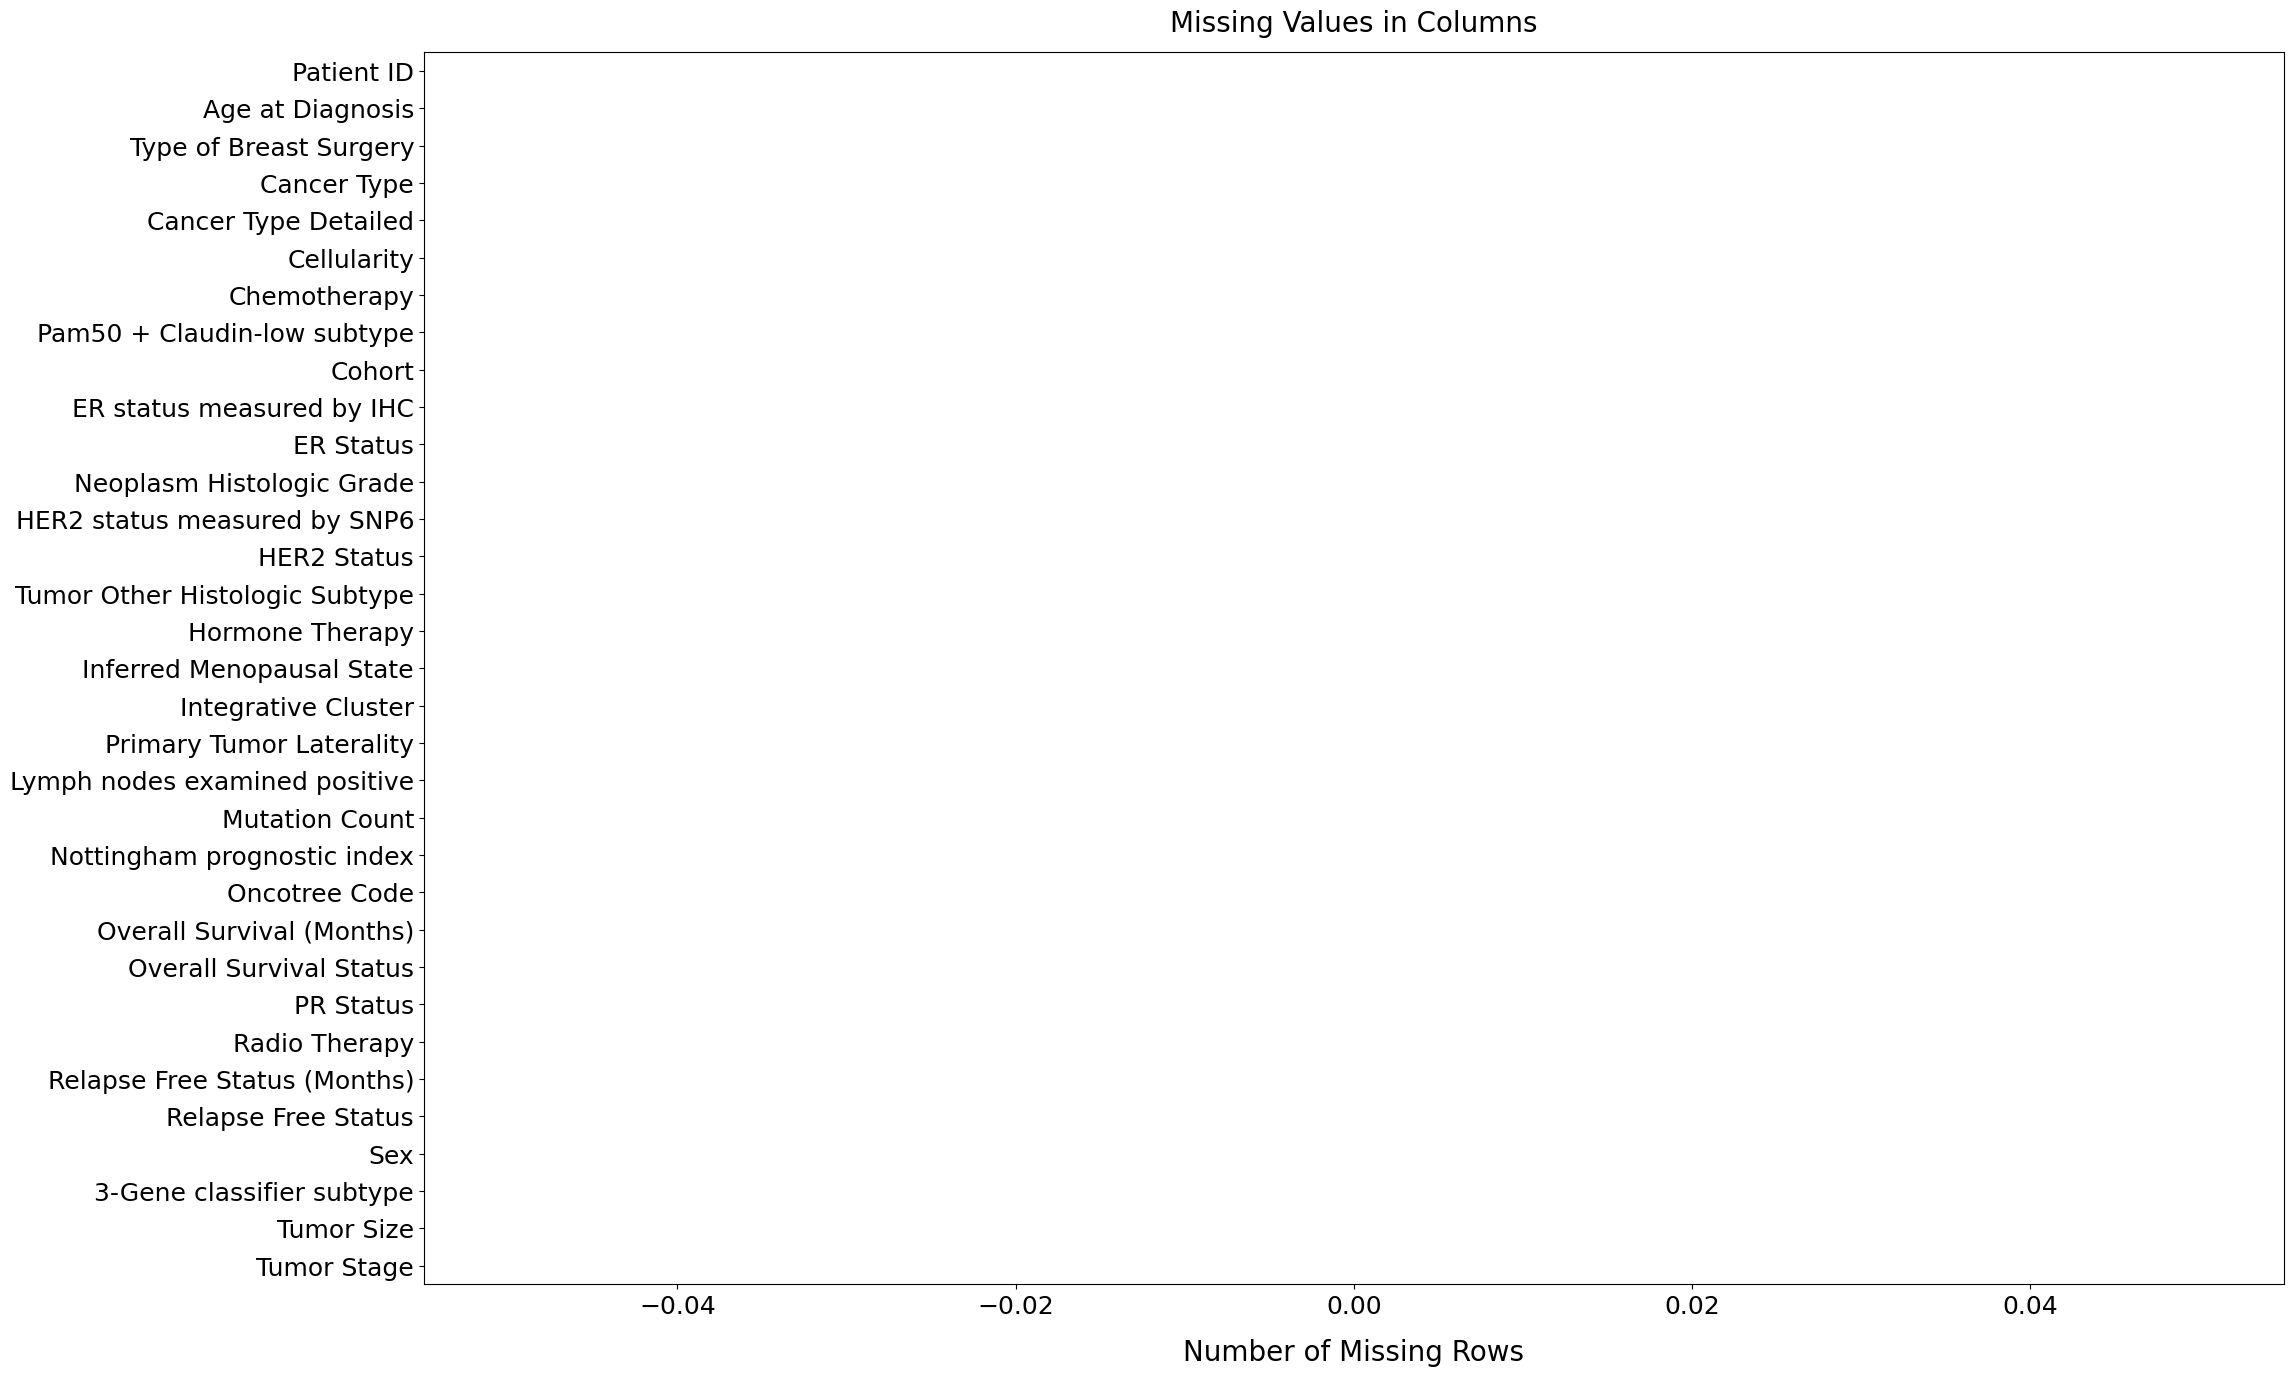

In [13]:
fig = plt.figure(figsize=(24, 16))

sns.barplot(x=patient_data.isnull().sum().sort_values(ascending=False).values,
            y=patient_data.isnull().sum().sort_values(ascending=False).index,
            palette='magma')

plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Missing Values in Columns', size=20, pad=15)

plt.show()

In [14]:
patient_data.columns

Index(['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'PR Status', 'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status', 'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage'], dtype='object')

In [15]:
object_cols = ['Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity',
               'Chemotherapy', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'ER status measured by IHC',
               'ER Status', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype',
               'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality',
               'Oncotree Code', 'PR Status', 'Radio Therapy', '3-Gene classifier subtype']

#for col in object_cols:
#patient_data[col] = np.uint8(LabelEncoder().fit_transform(patient_data[col]))
patient_data.columns = patient_data.columns.str.strip()
print(patient_data['Overall Survival Status'].unique())

['Living' 'Deceased']


In [16]:
patient_data['Overall Survival Status'] = np.uint8(patient_data['Overall Survival Status'].map({'Living': 0, 'Deceased': 1}))
patient_data['Relapse Free Status'] = np.uint8(patient_data['Relapse Free Status'].map({'Not Recurred': 0, 'Recurred': 1}))
patient_data["Tumor Stage"].unique()
# Drop rows where 'Tumor Stage' is 1.5
patient_data = patient_data[patient_data['Tumor Stage'] != 1.5]
patient_data["Tumor Stage"].unique()

array([2., 1., 4., 3., 0.])

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
patient_data.loc[:, 'Tumor Stage'] = label_encoder.fit_transform(patient_data['Tumor Stage'])
print(patient_data["Tumor Stage"].unique())
len(patient_data.columns)

[2. 1. 4. 3. 0.]


33

In [18]:
cols_to_drop = [
    'Integrative Cluster',  
    'Sex',                  
    'HER2 status measured by SNP6'  
]
patient_data = patient_data.drop(columns=cols_to_drop, errors='ignore')

In [19]:
one_hot_cols = [
    'Type of Breast Surgery', 'Cancer Type', 'Chemotherapy',
    'ER status measured by IHC', 'ER Status', 'HER2 Status',
    'Hormone Therapy', 'Inferred Menopausal State', 'Primary Tumor Laterality',
    'PR Status', 'Radio Therapy'
]
ordinal_mappings = {
    'Cellularity': ['Low', 'Moderate', 'High'],
    '3-Gene classifier subtype': [
        'ER-/HER2-', 
        'ER+/HER2- Low Prolif',
        'ER+/HER2- High Prolif', 
        'HER2+'
    ],
    'Tumor Stage': sorted(patient_data['Tumor Stage'].unique())  
}

In [20]:
high_card_cols = [
    'Cancer Type Detailed',
    'Pam50 + Claudin-low subtype',
    'Tumor Other Histologic Subtype',
    'Oncotree Code'
]

In [21]:
patient_data = pd.get_dummies(patient_data, columns=one_hot_cols, drop_first=True)

In [22]:
for col, levels in ordinal_mappings.items():
    if col in patient_data:
        patient_data[col] = patient_data[col].astype('category').cat.set_categories(levels, ordered=True).cat.codes

In [23]:
for col in high_card_cols:
    if col in patient_data:
        freq = patient_data[col].value_counts(normalize=True)
        patient_data[col+'_freq'] = patient_data[col].map(freq)
        patient_data = patient_data.drop(columns=[col])

In [24]:
print(f"\nFinal columns ({len(patient_data.columns)}):")
print(patient_data.columns.tolist())


Final columns (30):
['Patient ID', 'Age at Diagnosis', 'Cellularity', 'Cohort', 'Neoplasm Histologic Grade', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Overall Survival (Months)', 'Overall Survival Status', 'Relapse Free Status (Months)', 'Relapse Free Status', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage', 'Type of Breast Surgery_Mastectomy', 'Cancer Type_Breast Sarcoma', 'Chemotherapy_Yes', 'ER status measured by IHC_Positve', 'ER Status_Positive', 'HER2 Status_Positive', 'Hormone Therapy_Yes', 'Inferred Menopausal State_Pre', 'Primary Tumor Laterality_Right', 'PR Status_Positive', 'Radio Therapy_Yes', 'Cancer Type Detailed_freq', 'Pam50 + Claudin-low subtype_freq', 'Tumor Other Histologic Subtype_freq', 'Oncotree Code_freq']


In [25]:
patient_data.to_csv("patient_data_final.csv", index=False) 
patient_data.columns

Index(['Patient ID', 'Age at Diagnosis', 'Cellularity', 'Cohort', 'Neoplasm Histologic Grade', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Overall Survival (Months)', 'Overall Survival Status', 'Relapse Free Status (Months)', 'Relapse Free Status', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage', 'Type of Breast Surgery_Mastectomy', 'Cancer Type_Breast Sarcoma', 'Chemotherapy_Yes', 'ER status measured by IHC_Positve', 'ER Status_Positive', 'HER2 Status_Positive', 'Hormone Therapy_Yes', 'Inferred Menopausal State_Pre', 'Primary Tumor Laterality_Right', 'PR Status_Positive', 'Radio Therapy_Yes', 'Cancer Type Detailed_freq', 'Pam50 + Claudin-low subtype_freq', 'Tumor Other Histologic Subtype_freq', 'Oncotree Code_freq'], dtype='object')

In [26]:
unique_values = patient_data.apply(lambda col: col.unique())
print(unique_values)

Patient ID                             [MB-0000, MB-0002, MB-0005, MB-0006, MB-0008, ...
Age at Diagnosis                       [75.65, 43.19, 48.87, 47.68, 76.97, 78.77, 56....
Cellularity                                                                    [2, 1, 0]
Cohort                                     [1.0, 2.0, 3.0, 5.0, 4.0, 9.0, 7.0, 6.0, 8.0]
Neoplasm Histologic Grade                                                [3.0, 2.0, 1.0]
Lymph nodes examined positive          [10.0, 0.0, 1.0, 3.0, 8.0, 11.0, 24.0, 4.0, 16...
Mutation Count                         [5.0, 2.0, 1.0, 4.0, 3.0, 7.0, 8.0, 11.0, 14.0...
Nottingham prognostic index            [6.044, 4.02, 4.03, 4.05, 6.08, 4.062, 6.13, 4...
Overall Survival (Months)              [140.5, 84.63333333, 163.7, 164.93333330000002...
Overall Survival Status                                                           [0, 1]
Relapse Free Status (Months)           [138.65, 83.52, 151.28, 162.76, 18.55, 2.89, 1...
Relapse Free Status  

In [27]:
import numpy as np
binary_cols = [
    'Type of Breast Surgery_Mastectomy',
    'Cancer Type_Breast Sarcoma',
    'Chemotherapy_Yes',
    'ER status measured by IHC_Positve',
    'ER Status_Positive',
    'HER2 Status_Positive',
    'Hormone Therapy_Yes',
    'Inferred Menopausal State_Pre',
    'Primary Tumor Laterality_Right',
    'PR Status_Positive',
    'Radio Therapy_Yes'
]
patient_data[binary_cols] = patient_data[binary_cols].astype(np.uint8)
for col in binary_cols:
    print(f"{col}: {patient_data[col].unique()}")
    

Type of Breast Surgery_Mastectomy: [1 0]
Cancer Type_Breast Sarcoma: [0 1]
Chemotherapy_Yes: [0 1]
ER status measured by IHC_Positve: [1 0]
ER Status_Positive: [1 0]
HER2 Status_Positive: [0 1]
Hormone Therapy_Yes: [1 0]
Inferred Menopausal State_Pre: [0 1]
Primary Tumor Laterality_Right: [1 0]
PR Status_Positive: [0 1]
Radio Therapy_Yes: [1 0]


In [28]:
unique_values = patient_data.apply(lambda col: col.unique())
print(unique_values)

Patient ID                             [MB-0000, MB-0002, MB-0005, MB-0006, MB-0008, ...
Age at Diagnosis                       [75.65, 43.19, 48.87, 47.68, 76.97, 78.77, 56....
Cellularity                                                                    [2, 1, 0]
Cohort                                     [1.0, 2.0, 3.0, 5.0, 4.0, 9.0, 7.0, 6.0, 8.0]
Neoplasm Histologic Grade                                                [3.0, 2.0, 1.0]
Lymph nodes examined positive          [10.0, 0.0, 1.0, 3.0, 8.0, 11.0, 24.0, 4.0, 16...
Mutation Count                         [5.0, 2.0, 1.0, 4.0, 3.0, 7.0, 8.0, 11.0, 14.0...
Nottingham prognostic index            [6.044, 4.02, 4.03, 4.05, 6.08, 4.062, 6.13, 4...
Overall Survival (Months)              [140.5, 84.63333333, 163.7, 164.93333330000002...
Overall Survival Status                                                           [0, 1]
Relapse Free Status (Months)           [138.65, 83.52, 151.28, 162.76, 18.55, 2.89, 1...
Relapse Free Status  

In [29]:
#Multicolineaity Check using VIF
patient_data = patient_data.drop(columns=['Patient ID'])
from statsmodels.stats.outliers_influence import variance_inflation_factor
predictors = patient_data.drop(columns=['Overall Survival Status', 
                                      'Overall Survival (Months)',
                                      'Relapse Free Status',
                                      'Relapse Free Status (Months)'])
vif_data = pd.DataFrame()
vif_data["feature"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) 
                   for i in range(len(predictors.columns))]

print(vif_data.sort_values('VIF', ascending=False))

                                feature        VIF
21            Cancer Type Detailed_freq        inf
24                   Oncotree Code_freq        inf
6           Nottingham prognostic index  38.009043
3             Neoplasm Histologic Grade  27.099427
0                      Age at Diagnosis  24.023049
13    ER status measured by IHC_Positve  16.252418
9                           Tumor Stage  16.166463
23  Tumor Other Histologic Subtype_freq  15.997021
14                   ER Status_Positive  15.660888
7             3-Gene classifier subtype   6.968356
1                           Cellularity   6.898386
22     Pam50 + Claudin-low subtype_freq   6.108903
8                            Tumor Size   5.151573
16                  Hormone Therapy_Yes   4.925886
10    Type of Breast Surgery_Mastectomy   4.602310
20                    Radio Therapy_Yes   4.238582
19                   PR Status_Positive   4.076991
2                                Cohort   3.329108
5                        Mutati

In [30]:
patient_data = patient_data.drop(columns=[
    'Cancer Type Detailed_freq',  # VIF = ∞
    'Oncotree Code_freq'          # VIF = ∞
])

In [31]:
predictors = patient_data.drop(columns=['Overall Survival Status', 
                                      'Overall Survival (Months)',
                                      'Relapse Free Status',
                                      'Relapse Free Status (Months)'])
vif_data = pd.DataFrame()
vif_data["feature"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) 
                   for i in range(len(predictors.columns))]
print(vif_data.sort_values('VIF', ascending=False))

patient_data.columns

                                feature        VIF
6           Nottingham prognostic index  37.795679
3             Neoplasm Histologic Grade  27.019831
0                      Age at Diagnosis  23.980659
13    ER status measured by IHC_Positve  16.185470
14                   ER Status_Positive  15.652128
9                           Tumor Stage  15.563453
1                           Cellularity   6.866399
7             3-Gene classifier subtype   6.419488
21     Pam50 + Claudin-low subtype_freq   6.030267
22  Tumor Other Histologic Subtype_freq   5.998843
8                            Tumor Size   5.104799
16                  Hormone Therapy_Yes   4.817680
10    Type of Breast Surgery_Mastectomy   4.563559
20                    Radio Therapy_Yes   4.198935
19                   PR Status_Positive   4.066167
2                                Cohort   3.304852
5                        Mutation Count   3.156908
12                     Chemotherapy_Yes   2.073529
17        Inferred Menopausal S

Index(['Age at Diagnosis', 'Cellularity', 'Cohort', 'Neoplasm Histologic Grade', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Overall Survival (Months)', 'Overall Survival Status', 'Relapse Free Status (Months)', 'Relapse Free Status', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage', 'Type of Breast Surgery_Mastectomy', 'Cancer Type_Breast Sarcoma', 'Chemotherapy_Yes', 'ER status measured by IHC_Positve', 'ER Status_Positive', 'HER2 Status_Positive', 'Hormone Therapy_Yes', 'Inferred Menopausal State_Pre', 'Primary Tumor Laterality_Right', 'PR Status_Positive', 'Radio Therapy_Yes', 'Pam50 + Claudin-low subtype_freq', 'Tumor Other Histologic Subtype_freq'], dtype='object')

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
columns_to_drop = [
    'Nottingham prognostic index',  
    'ER status measured by IHC_Positve'  
]

patient_data = patient_data.drop(
    columns=[col for col in columns_to_drop if col in patient_data.columns],
    errors='ignore'  )

predictors = patient_data.drop(columns=[
    'Overall Survival Status',
    'Overall Survival (Months)',
    'Relapse Free Status',
    'Relapse Free Status (Months)'
], errors='ignore')

vif_data = pd.DataFrame()
vif_data["feature"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) 
                   for i in range(len(predictors.columns))]

print("\nUpdated VIF after dropping problematic columns:")
print(vif_data.sort_values('VIF', ascending=False))


Updated VIF after dropping problematic columns:
                                feature        VIF
0                      Age at Diagnosis  22.931726
3             Neoplasm Histologic Grade  16.593141
8                           Tumor Stage  14.266904
1                           Cellularity   6.763188
6             3-Gene classifier subtype   6.413066
12                   ER Status_Positive   6.313383
19     Pam50 + Claudin-low subtype_freq   6.027089
20  Tumor Other Histologic Subtype_freq   5.960887
7                            Tumor Size   5.097608
14                  Hormone Therapy_Yes   4.533415
9     Type of Breast Surgery_Mastectomy   4.506414
18                    Radio Therapy_Yes   4.131596
17                   PR Status_Positive   4.032120
2                                Cohort   3.283743
5                        Mutation Count   3.146044
11                     Chemotherapy_Yes   1.976722
13                 HER2 Status_Positive   1.830423
15        Inferred Menopausal Sta

In [33]:
patient_data_reduced = patient_data.drop(columns=['Tumor Stage',"Tumor Size"], errors='ignore')
predictors_reduced = patient_data_reduced.drop(columns=[
    'Overall Survival Status', 'Overall Survival (Months)',
    'Relapse Free Status', 'Relapse Free Status (Months)'
], errors='ignore')

vif_reduced = pd.DataFrame()
vif_reduced["feature"] = predictors_reduced.columns
vif_reduced["VIF"] = [variance_inflation_factor(predictors_reduced.values, i) 
                     for i in range(len(predictors_reduced.columns))]

print("VIF after ONLY removing Tumor Stage:")
print(vif_reduced.sort_values('VIF', ascending=False))

VIF after ONLY removing Tumor Stage:
                                feature        VIF
0                      Age at Diagnosis  20.487251
3             Neoplasm Histologic Grade  16.304438
1                           Cellularity   6.753013
6             3-Gene classifier subtype   6.372984
10                   ER Status_Positive   6.312823
17     Pam50 + Claudin-low subtype_freq   6.013872
18  Tumor Other Histologic Subtype_freq   5.949269
12                  Hormone Therapy_Yes   4.457701
7     Type of Breast Surgery_Mastectomy   4.276370
16                    Radio Therapy_Yes   4.071147
15                   PR Status_Positive   4.027606
2                                Cohort   3.256262
5                        Mutation Count   3.135253
9                      Chemotherapy_Yes   1.874290
11                 HER2 Status_Positive   1.825306
13        Inferred Menopausal State_Pre   1.765188
14       Primary Tumor Laterality_Right   1.739951
4         Lymph nodes examined positive   1.3

In [34]:
patient_data_final = patient_data.drop(columns=[
    'Age at Diagnosis',           
    'Neoplasm Histologic Grade',  
    'Tumor Stage'                 
], errors='ignore')

predictors_final = patient_data_final.drop(columns=[
    'Overall Survival Status',
    'Overall Survival (Months)', 
    'Relapse Free Status',
    'Relapse Free Status (Months)'
], errors='ignore')

vif_final = pd.DataFrame()
vif_final["feature"] = predictors_final.columns
vif_final["VIF"] = [variance_inflation_factor(predictors_final.values, i) 
                   for i in range(len(predictors_final.columns))]

print("Final VIF Values:")
print(vif_final.sort_values('VIF', ascending=False).head(10))


Final VIF Values:
                                feature       VIF
0                           Cellularity  6.422005
4             3-Gene classifier subtype  6.289413
16     Pam50 + Claudin-low subtype_freq  5.937716
9                    ER Status_Positive  5.264224
17  Tumor Other Histologic Subtype_freq  5.010122
5                            Tumor Size  4.419898
11                  Hormone Therapy_Yes  4.390217
6     Type of Breast Surgery_Mastectomy  4.200253
14                   PR Status_Positive  4.022961
15                    Radio Therapy_Yes  3.820406


In [35]:
patient_data_final.columns
print(patient_data_final.isnull().sum())

Cellularity                            0
Cohort                                 0
Lymph nodes examined positive          0
Mutation Count                         0
Overall Survival (Months)              0
Overall Survival Status                0
Relapse Free Status (Months)           0
Relapse Free Status                    0
3-Gene classifier subtype              0
Tumor Size                             0
Type of Breast Surgery_Mastectomy      0
Cancer Type_Breast Sarcoma             0
Chemotherapy_Yes                       0
ER Status_Positive                     0
HER2 Status_Positive                   0
Hormone Therapy_Yes                    0
Inferred Menopausal State_Pre          0
Primary Tumor Laterality_Right         0
PR Status_Positive                     0
Radio Therapy_Yes                      0
Pam50 + Claudin-low subtype_freq       0
Tumor Other Histologic Subtype_freq    0
dtype: int64


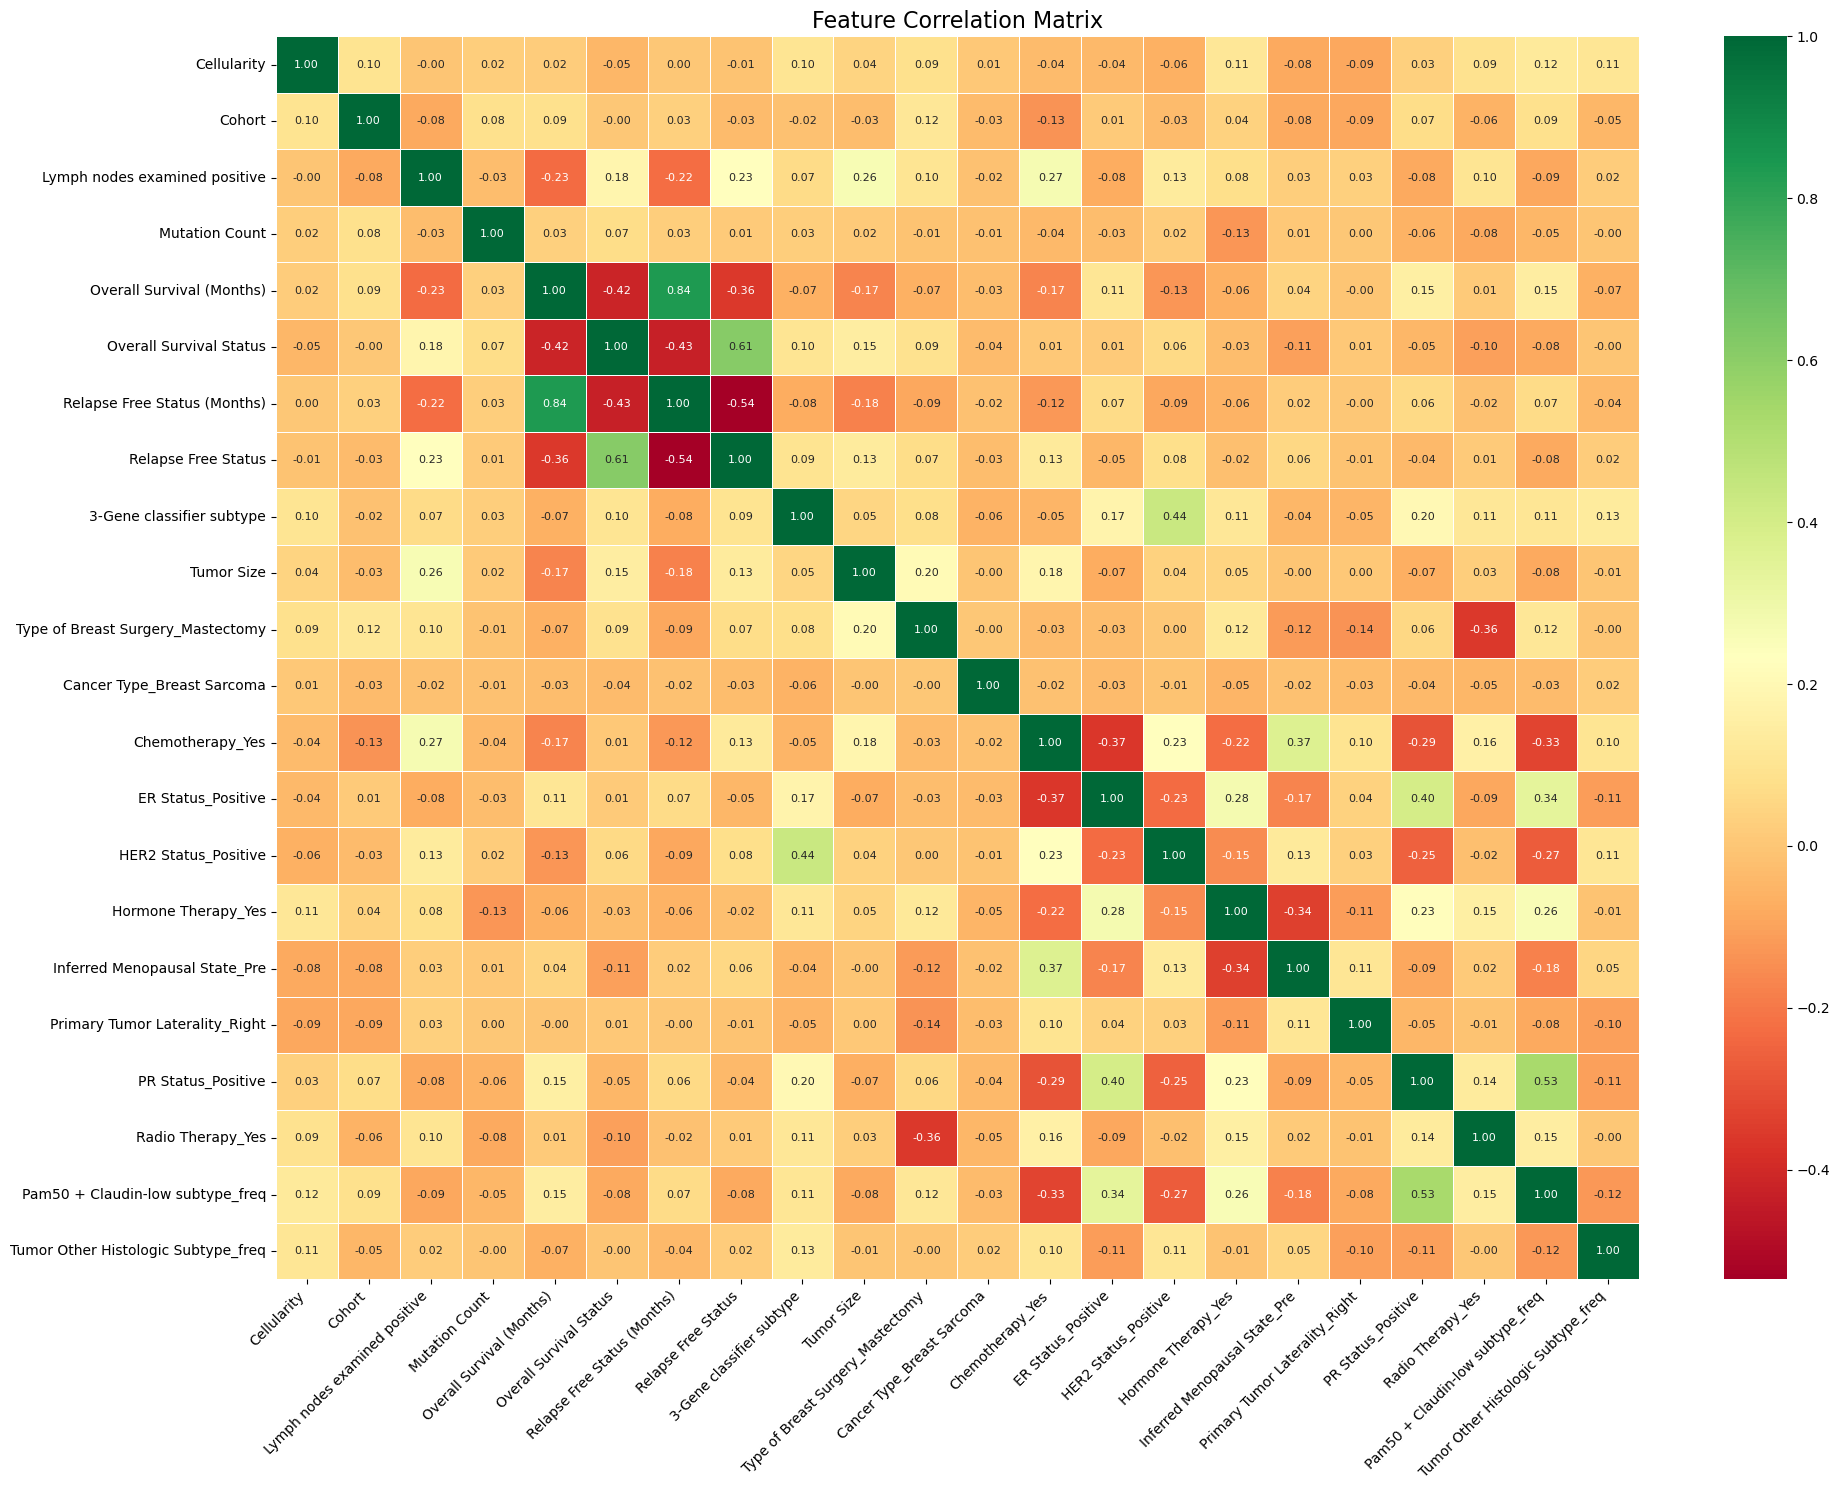


Highly correlated features (|r| > 0.7):
Overall Survival (Months)  Relapse Free Status (Months)    0.837349
dtype: float64


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = patient_data_final.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdYlGn', 
            annot_kws={"size": 8}, linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Get highly correlated pairs (absolute correlation > 0.7)
high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = high_corr.stack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs) > 0.7]
print("\nHighly correlated features (|r| > 0.7):")
print(high_corr_pairs)

In [37]:
from lifelines import CoxPHFitter
patient_data_final['Overall Survival (Months)'] = patient_data_final['Overall Survival (Months)'].astype(float)
print(patient_data_final[['Overall Survival (Months)', 'Overall Survival Status']].isnull().sum())

Overall Survival (Months)    0
Overall Survival Status      0
dtype: int64


In [38]:
cph = CoxPHFitter()
cph.fit(
    patient_data_final,
    duration_col='Overall Survival (Months)',
    event_col='Overall Survival Status'
)
print("\nModel Summary:")
cph.print_summary(decimals=3, style='ascii')


Model Summary:
<lifelines.CoxPHFitter: fitted with 2507 total observations, 1165 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'Overall Survival Status'
      baseline estimation = breslow
   number of observations = 2507
number of events observed = 1342
   partial log-likelihood = -8606.599
         time fit was run = 2025-07-29 05:28:25 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
Cellularity                          -0.097     0.908     0.045          -0.185          -0.009               0.831               0.991
Cohort                               -0.007     0.993     0.014          -0.035           0.021               0.966               1.021
Lymph nodes examined positive         

In [39]:
significant_vars = cph.summary[cph.summary["p"] < 0.05]
print(significant_vars)

                                      coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  cmp to          z              p    -log2(p)
covariate                                                                                                                                                                              
Cellularity                      -0.096828   0.907712  0.044971       -0.184971       -0.008686             0.831129             0.991352     0.0  -2.153104   3.131054e-02    4.997208
Lymph nodes examined positive     0.027702   1.028089  0.006083        0.015779        0.039624             1.015904             1.040420     0.0   4.553784   5.268955e-06   17.534052
Mutation Count                    0.012970   1.013054  0.006159        0.000899        0.025040             1.000900             1.025356     0.0   2.105982   3.520593e-02    4.828038
Relapse Free Status (Months)     -0.015188   0.984927  0.000572       -0.016308 


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2507 total observations, 1165 right-censored observations>
         test_name = proportional_hazard_test

---
                                          test_statistic      p  -log2(p)
3-Gene classifier subtype           km              4.20   0.04      4.63
                                    rank            3.11   0.08      3.68
Cancer Type_Breast Sarcoma          km              0.00   1.00      0.00
                                    rank            0.00   1.00      0.00
Cellularity                         km              0.04   0.83      0.26
                                    rank            0.10   0.75      0.42
Chemotherapy_Yes                    km              5.61   0.02      5.81
                                    rank            5.12   0.02      5.40
Cohort                              km              0.41   0.52      0.94
                                    rank            0.22   0.64      0.65
ER Status_Positive                  km              0.32   0.57      0.80
                                    rank            0.00   0.99      0.01
HER2 Status_Positive                km              6.53   0.01      6.56
                                    rank            6.12   0.01      6.22
Hormone Therapy_Yes                 km             29.40 <0.005     24.02
                                    rank           35.62 <0.005     28.63
Inferred Menopausal State_Pre       km             14.14 <0.005     12.52
                                    rank           15.95 <0.005     13.91
Lymph nodes examined positive       km              0.07   0.79      0.35
                                    rank            0.34   0.56      0.83
Mutation Count                      km              4.17   0.04      4.60
                                    rank            2.91   0.09      3.51
PR Status_Positive                  km             11.26 <0.005     10.31
                                    rank           14.27 <0.005     12.63
Pam50 + Claudin-low subtype_freq    km             40.48 <0.005     32.23
                                    rank           34.94 <0.005     28.13
Primary Tumor Laterality_Right      km              2.02   0.15      2.69
                                    rank            1.12   0.29      1.79
Radio Therapy_Yes                   km              0.00   0.97      0.04
                                    rank            0.48   0.49      1.03
Relapse Free Status                 km             20.25 <0.005     17.17
                                    rank           22.44 <0.005     18.81
Relapse Free Status (Months)        km            427.64 <0.005    313.17
                                    rank          375.35 <0.005    275.36
Tumor Other Histologic Subtype_freq km              0.02   0.90      0.15
                                    rank            0.01   0.92      0.12
Tumor Size                          km              5.66   0.02      5.85
                                    rank            5.18   0.02      5.45
Type of Breast Surgery_Mastectomy   km              3.71   0.05      4.20
                                    rank            2.49   0.11      3.12



1. Variable 'Relapse Free Status (Months)' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Relapse Free Status (Months)' might be incorrect.
That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive
to incorrect functional forms. See documentation in link [D] below on how to specify a functional
form.

   Advice 2: try binning the variable 'Relapse Free Status (Months)' using pd.cut, and then specify
it in `strata=['Relapse Free Status (Months)', ...]` in the call in `.fit`. See documentation in
link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Relapse Free Status' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Relapse Free Status', ...]`
in the call in `.fit`. See docu

[[<Axes: xlabel='rank-transformed time\n(p=0.7491)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8345)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6385)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5203)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5612)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7857)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0879)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0413)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0780)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0405)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0229)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0174)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1149)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0542)'>],
 [<Axes: xlabel='rank-transformed tim

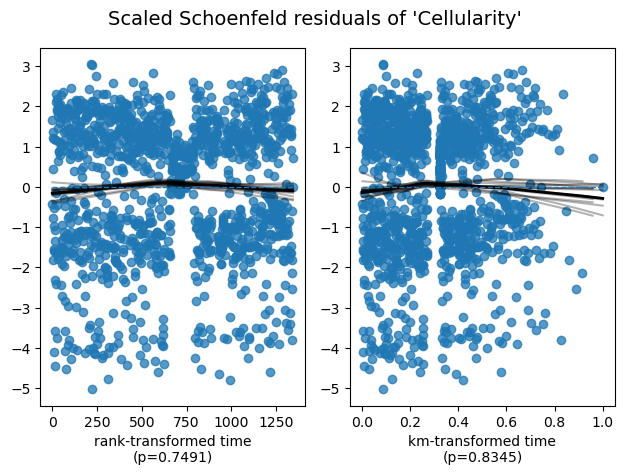

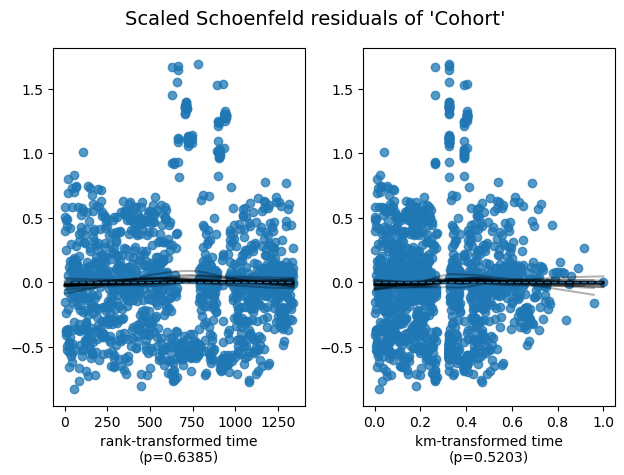

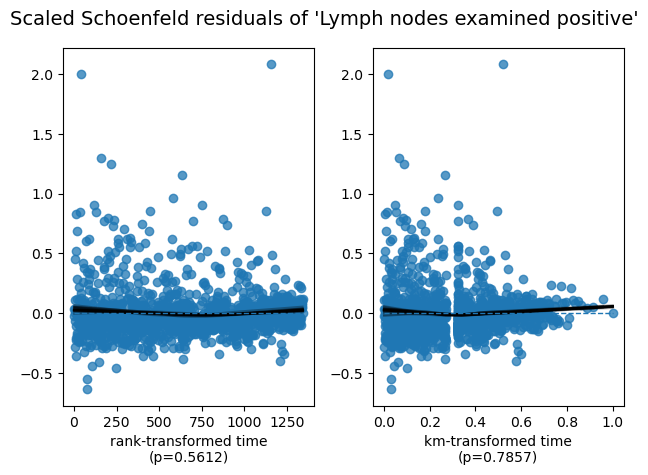

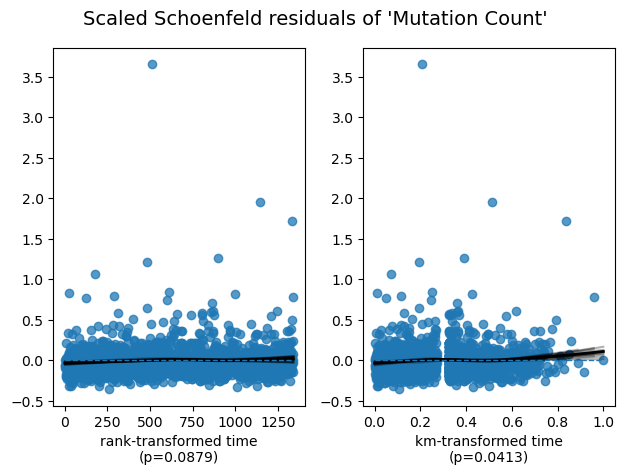

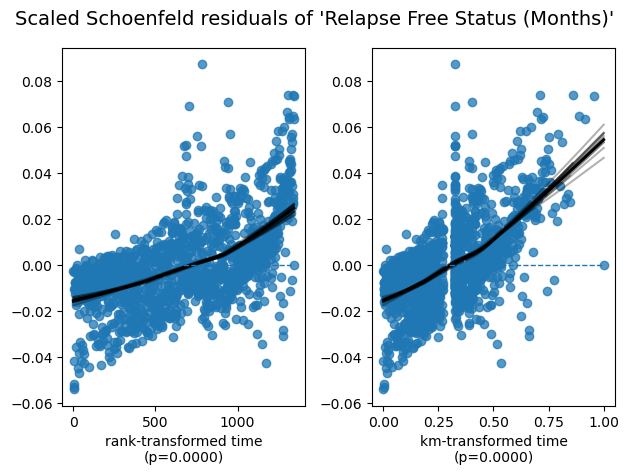

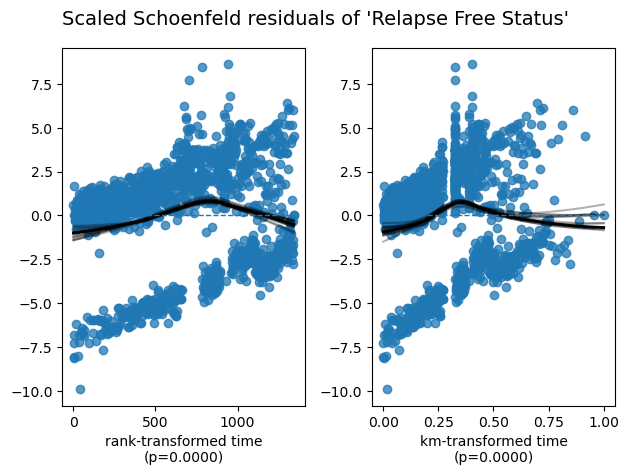

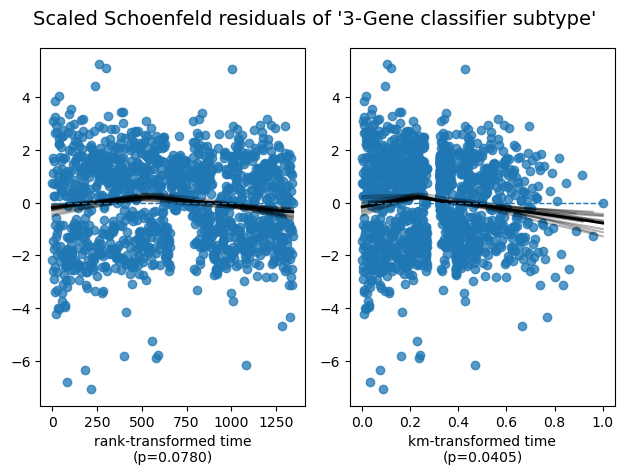

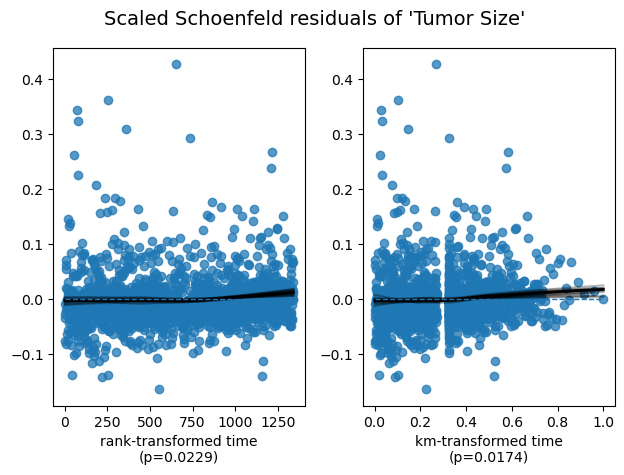

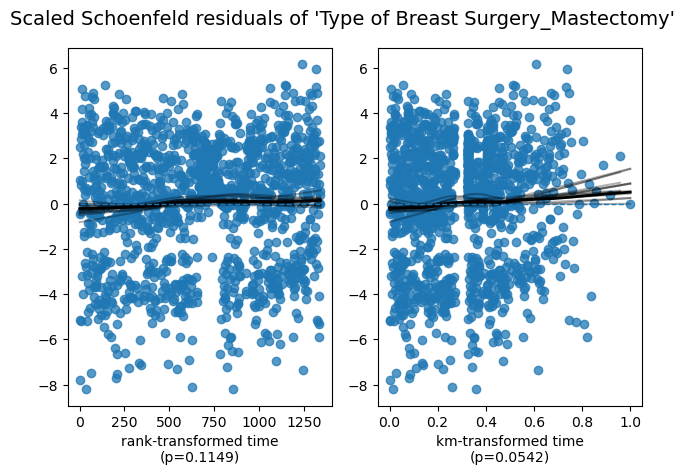

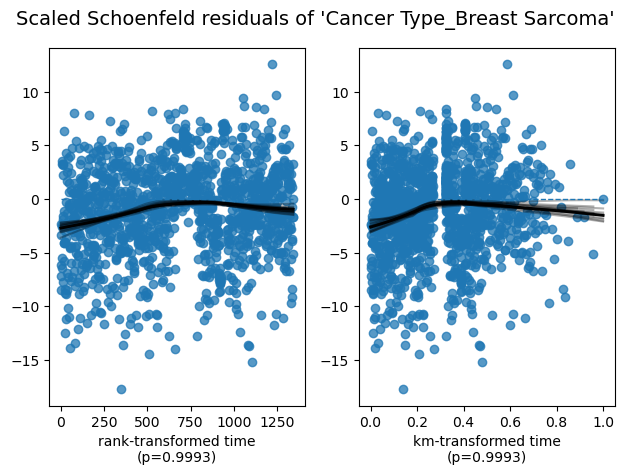

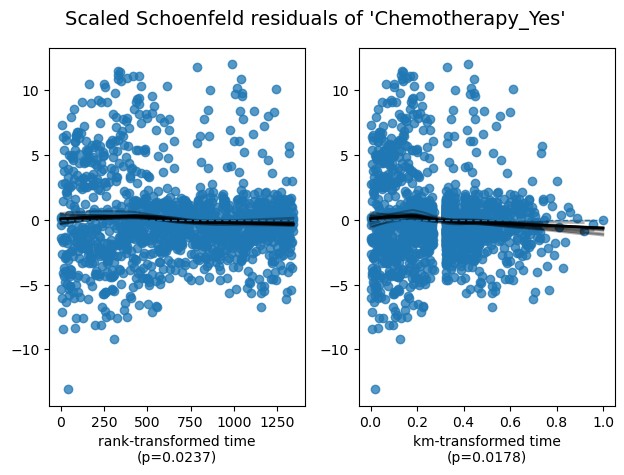

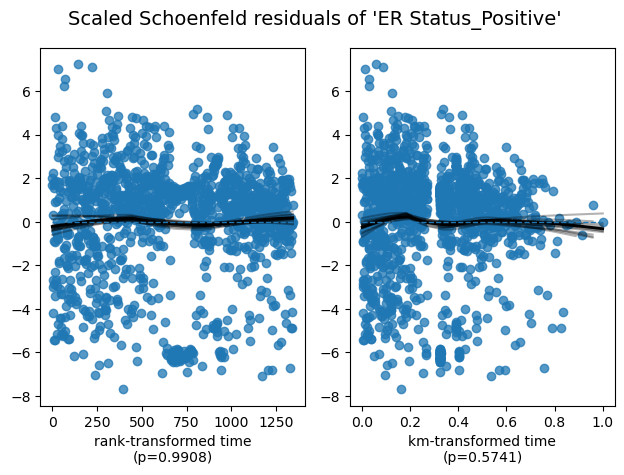

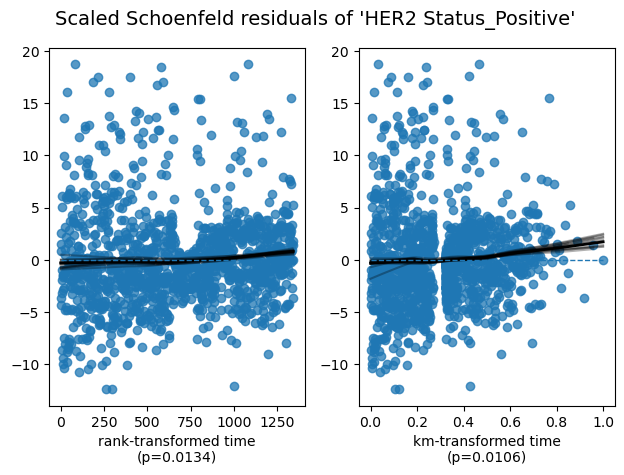

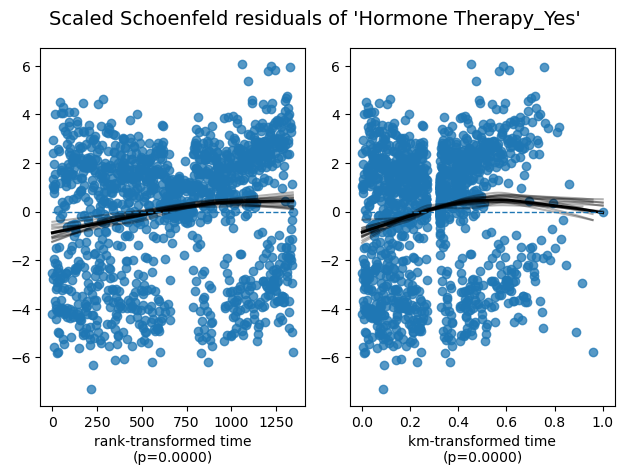

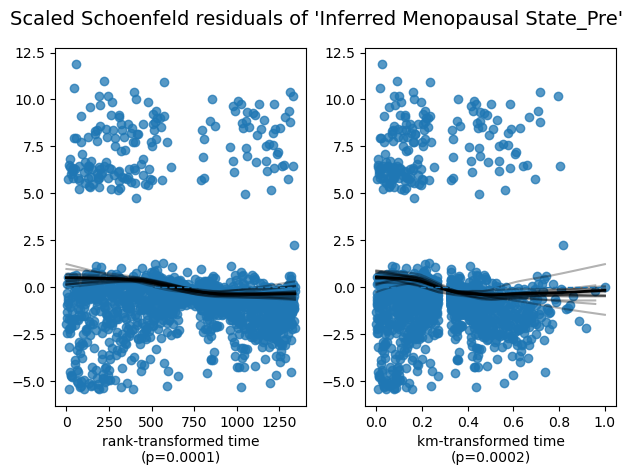

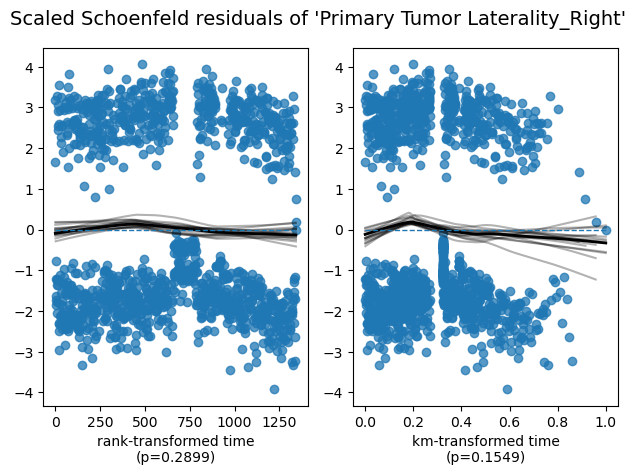

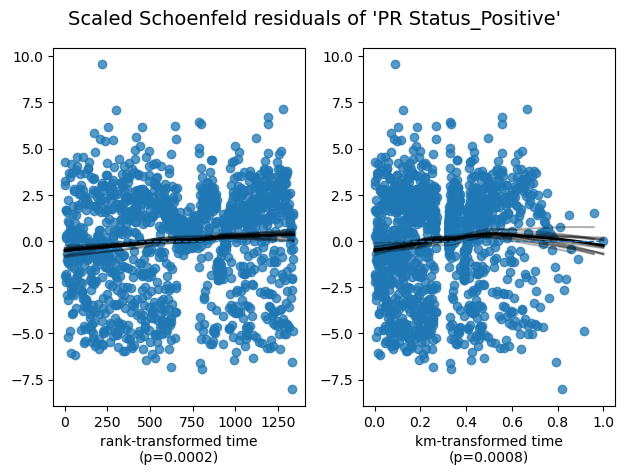

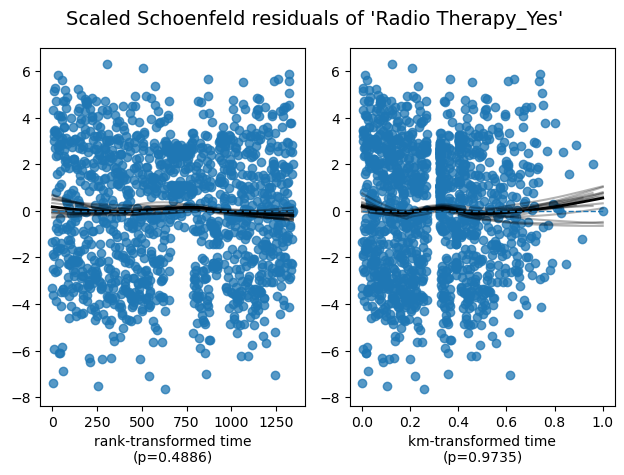

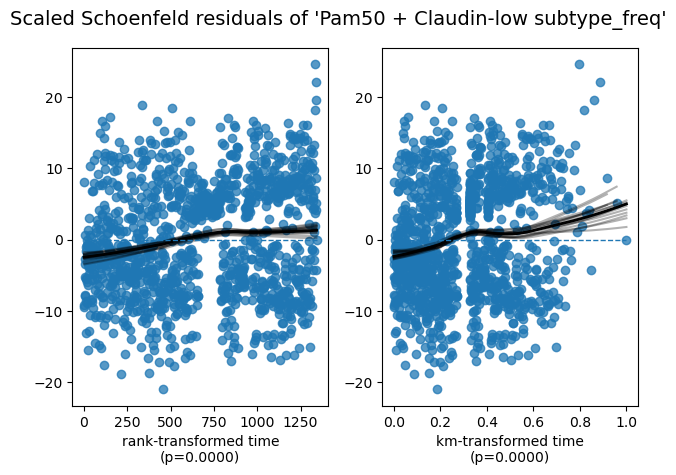

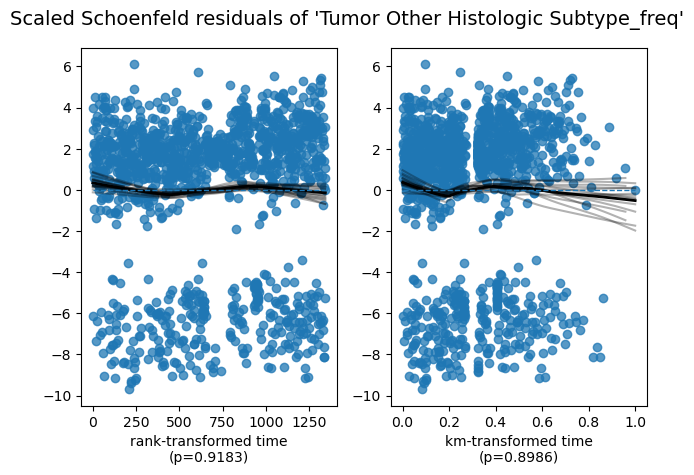

In [40]:
# Test proportional hazards assumption
test_df = patient_data_final.copy()
for col in test_df.columns:
    if pd.api.types.is_interval_dtype(test_df[col]):
        test_df[col] = test_df[col].astype(str)
cph.check_assumptions(test_df, show_plots=True)

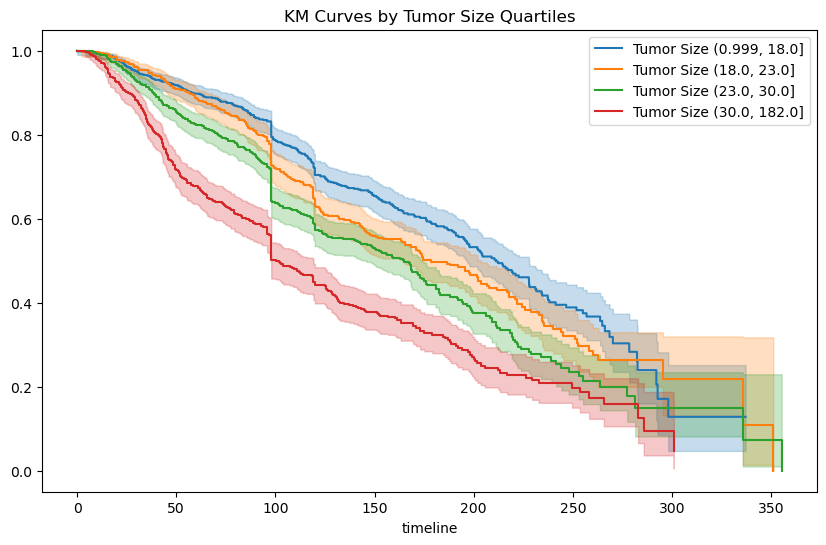

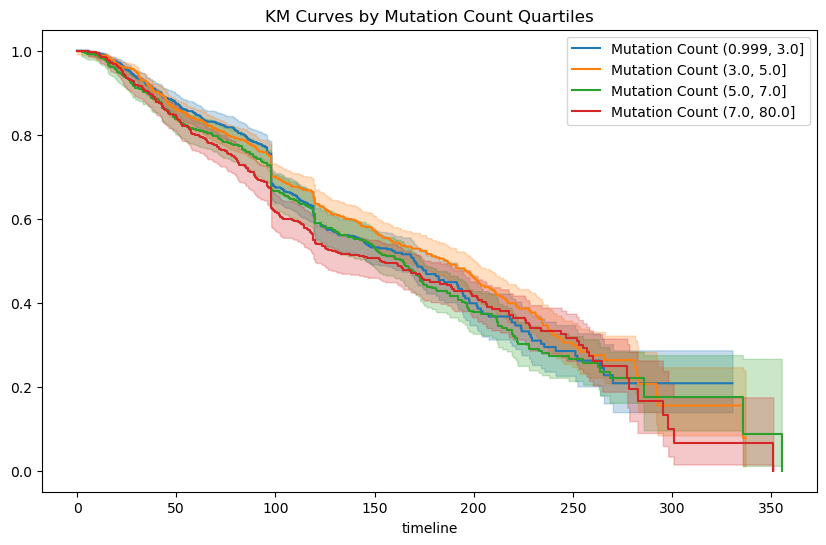

In [41]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

for var in ['Tumor Size', 'Mutation Count']:
    if var in patient_data_final.columns:
        patient_data_final[f'{var}_group'] = pd.qcut(patient_data_final[var], q=4)
        kmf = KaplanMeierFitter()
        
        plt.figure(figsize=(10,6))
        for name, grouped_df in patient_data_final.groupby(f'{var}_group'):
            kmf.fit(grouped_df['Overall Survival (Months)'], 
                    grouped_df['Overall Survival Status'],
                    label=f'{var} {name}')
            kmf.plot_survival_function()
        
        plt.title(f'KM Curves by {var} Quartiles')
        plt.show()

In [49]:
#Logistic Regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

X = patient_data_final.drop(columns=['Overall Survival Status', 'Overall Survival (Months)'])
y = patient_data_final['Overall Survival Status']

import pandas.api.types as ptypes

# Step 1: Identify problematic columns
non_numeric_cols = []
interval_cols = []

for col in X.columns:
    if ptypes.is_interval_dtype(X[col]):
        interval_cols.append(col)
    elif not ptypes.is_numeric_dtype(X[col]):
        non_numeric_cols.append(col)


for col in interval_cols:
    X[col] = X[col].apply(lambda x: x.mid if pd.notnull(x) else np.nan)

from sklearn.preprocessing import LabelEncoder

for col in non_numeric_cols:
    X[col] = X[col].astype(str) 
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

log_reg = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

log_reg.fit(X_train_processed, y_train)

y_pred = log_reg.predict(X_test_processed)
y_proba = log_reg.predict_proba(X_test_processed)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8107569721115537
AUC Score: 0.8889385260941016
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.81       233
           1       0.89      0.74      0.81       269

    accuracy                           0.81       502
   macro avg       0.82      0.82      0.81       502
weighted avg       0.82      0.81      0.81       502

Confusion Matrix:
 [[209  24]
 [ 71 198]]


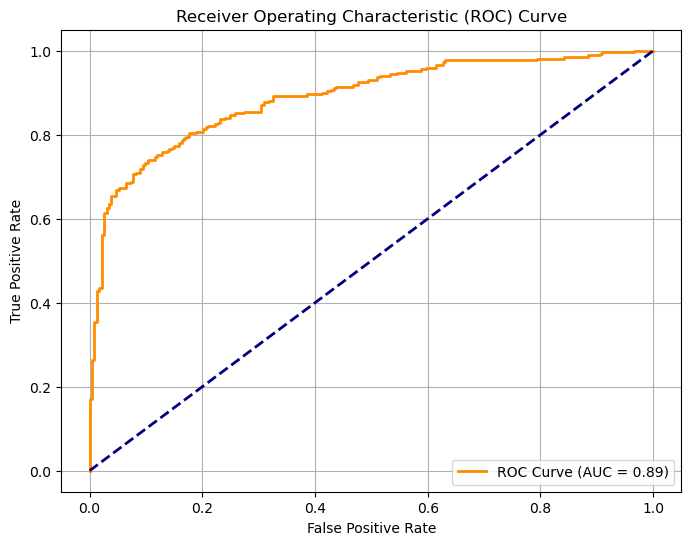

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


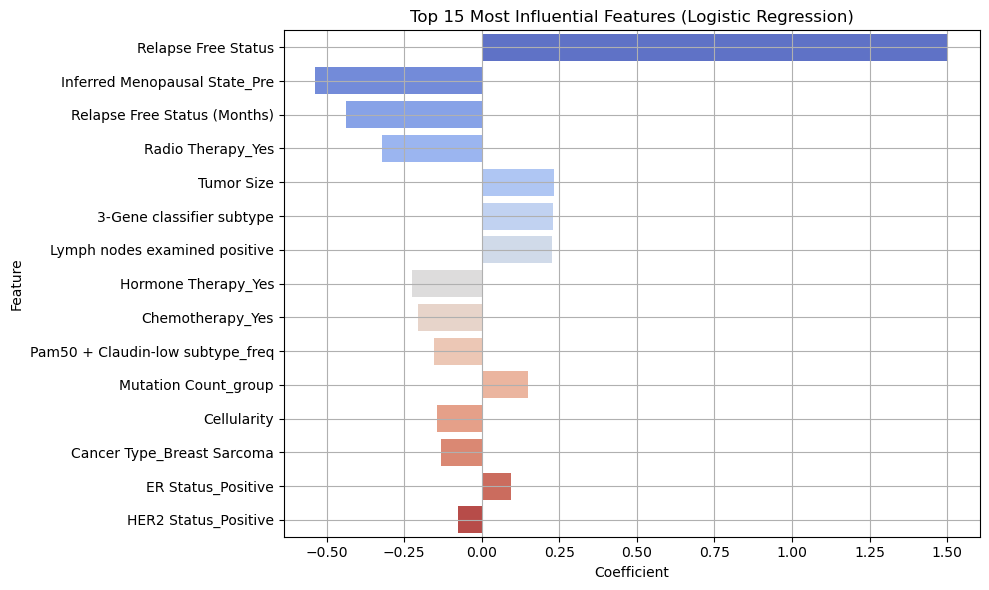

In [51]:
coefficients = log_reg.coef_[0]
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

importance_df['abs_coef'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='abs_coef', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='coolwarm')
plt.title('Top 15 Most Influential Features (Logistic Regression)')
plt.grid(True)
plt.tight_layout()
plt.show()
